In [76]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style()

In [79]:
class OneHotEncode():
    def fit(self, y):
        # get an array of unique labels
        self.labels = np.unique(y)
        # create an column vector where each entry is the index of the corresponding label
        # np.where(...) returns a tuple (matching the dim of the array) containing the matching indices
        self.y_label_indices = np.apply_along_axis(lambda y : [np.where(self.labels == y)[0][0]], axis=1, arr=y)

    def encode_row_by_label_index(self, label_index):
        # initialize a zero vector whose length is the number of unique labels
        ret = np.zeros(self.labels.shape[0])
        # set the value corresponding to the label index = 1
        ret[label_index] = 1
        return ret
        
    def transform(self, y = None):
        # for each index in the index column vector, create the corresponding encoded vector
        return np.apply_along_axis(self.encode_row_by_label_index, axis=1, arr=self.y_label_indices)
    
    def fit_transform(self, y):
        self.fit(y)
        return self.transform(y)

In [80]:
OneHotEncode().fit_transform(
            [['cat'],
            ['dog'],
            ['horse'],
            ['dog'],
            ['cat'],
            ['cat'],
            ['dog'],
            ['horse'],
            ['wolf']])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [81]:
def mean_squared_error(y1, y2):
    delta = y1 - y2
    m = delta.shape[0]
    squared_delta = np.apply_along_axis(lambda x : x**2, axis=1, arr=delta)
    return (1.0 / m) * np.sum(squared_delta)

In [82]:
from sklearn.metrics import mean_squared_error as smse

y1 = np.array([[1], [3], [5], [2], [0]])
y2 = np.array([[-3], [-7], [3], [1], [-4]])

print('sciki mse = ', smse(y1, y2))
print('my mse = ', mean_squared_error(y1, y2))

sciki mse =  27.4
my mse =  27.400000000000002


In [83]:
a = np.array([[1 ,2],
    [3, 4]])

b = np.array([[1, 0.5],
     [0.33, 0.25]])

c = np.einsum('ij,ij->i',a,b)
print(c)
np.sum(c)

print(np.amax(a, axis = 1, keepdims = True))

[2.   1.99]
[[2]
 [4]]


In [84]:
class SoftmaxEarlyStop():
    
    def __init__(self, **kwargs):
        
        self.max_epochs = 1000
        self.stopping_iters = 50
        self.val = 0.2
        self.eta = 0.08
        self.tol = 1e-03
        self.early_stop = True
        self.seed = 42
        
        for key, value in kwargs.items():
            if key == 'max_epochs':
                self.max_epochs = value
            elif key == 'stopping_iters':
                self.stopping_iters = value
            elif key == 'val':
                self.val = value
            elif key == 'eta':
                self.eta = value
            elif key == 'tol':
                self.tol = value
            elif key == 'early_stop':
                self.early_stop = value
            elif key == 'seed':
                self.seed = value
        
    def add_bias_column(self, X):
        return np.c_[np.ones((X.shape[0], 1)), X]
    
    def softmax(self, X, theta):
        
        # weights * X + bias
        s = np.dot(X, theta)
        
        # probability weights
        exp_s = np.exp(s)
        exp_s_row_sums = np.sum(exp_s, axis = 1, keepdims = True)
        
        # probability
        return exp_s / exp_s_row_sums
    
    def batch_gradient(self, X, y, theta, m):
        # softmax
        p = self.softmax(X, theta)

        # batch gradient
        return (1.0 / m) * np.dot(X.T, (p - y))
    
    def cross_entropy_cost(self, y, p, m):
        return (-1.0 / m) * np.sum(np.einsum('ij,ij->i', y, np.log(p)))
    
    def fit(self, X, y):
        # sety random state
        np.random.seed(self.seed)
        
        # Split validation and train sets
        total_examples = X.shape[0]
        training_index = int((1.0 - self.val) * total_examples)
        X_train = X[:training_index, :]
        y_train = y[:training_index, :]
        X_val = X[training_index:, :]
        y_val = y[training_index:, :]

        # add column for the bias term
        X_train_with_bias = self.add_bias_column(X_train)
        X_val_with_bias = self.add_bias_column(X_val)

        # rows
        m = X_train_with_bias.shape[0]
        m_val = X_val_with_bias.shape[0]
        # column
        n = X_train_with_bias.shape[1]
        # one hot encode y
        one_hot_encoded_y_train = OneHotEncode().fit_transform(y_train)
        one_hot_encoded_y_val = OneHotEncode().fit_transform(y_val)
        k = one_hot_encoded_y_train.shape[1]

        # initalize theta with normal distribution
        theta = np.random.normal(size = (n, k))
        self.best_theta_ = theta.copy()
        
        
        min_val_error = float('inf')
        self.best_epoch_ = 0
        
        self.train_errors_ = []
        self.val_errors_ = []
        
        for epoch in range(self.max_epochs):
            # gradient descent
            gradient = self.batch_gradient(X_train_with_bias, one_hot_encoded_y_train, theta, m)
            theta = theta - self.eta * gradient
            # predict probabilities
            y_train_predict = self.softmax(X_train_with_bias, theta)
            y_val_predict = self.softmax(X_val_with_bias, theta)
            # calculate errors
            train_error = self.cross_entropy_cost(one_hot_encoded_y_train, y_train_predict, m)
            val_error = self.cross_entropy_cost(one_hot_encoded_y_val, y_val_predict, m_val)
            # store errors
            self.train_errors_.append(train_error)
            self.val_errors_.append(val_error)
            # check for best theta so far
            if val_error < min_val_error - self.tol :
                min_val_error = val_error
                self.best_epoch_ = epoch
                self.best_theta_ = theta
            elif self.early_stop and epoch - self.best_epoch_ > self.stopping_iters:
                break
                
                
    def predict_proba(self, X):
        X_with_bias = self.add_bias_column(X)
        return self.softmax(X_with_bias, self.best_theta_)
    
    def predict(self, X):
        return np.apply_along_axis(lambda x : [np.argmax(x)], axis=1, arr = self.predict_proba(X))

In [85]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris['data']
y = iris['target']
print(X.shape)
print(y.shape)

(150, 4)
(150,)


In [86]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [87]:
x = np.array([[1,2,3],
            [1,2,3]])
x[:,-1:]
print(np.random.shuffle(x))

None


In [88]:
X_and_y = np.c_[X, y.reshape(150, 1)]
np.random.seed(1)
np.random.shuffle(X_and_y)
X_shuffled = X_and_y[:, :-1]
y_shuffled = X_and_y[:, -1:]

print(X_shuffled.shape)
print(y_shuffled.shape)

(150, 4)
(150, 1)


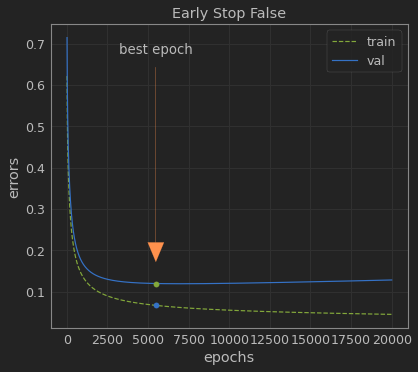

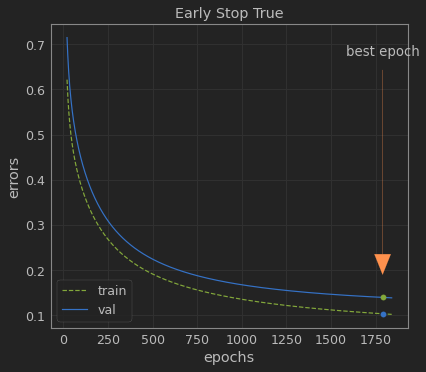

In [89]:
sftmx_clfs = []

# run 2 softmax classifiers for 20000 epochs one with and one without early stopping
for i in range(0, 2):
    sftmx_clf = SoftmaxEarlyStop(max_epochs = 20000, early_stop = i)
    sftmx_clf.fit(X_shuffled, y_shuffled)
    sftmx_clfs.append(sftmx_clf)
    
    # start after a few epochs because the sharp drop over the first few epochs makes it hard to read the graph
    start_epoch = 20
    epochs = range(start_epoch, len(sftmx_clf.train_errors_))

    # plot train vs validation errors
    plt.plot(epochs, sftmx_clf.train_errors_[start_epoch:], 'g--', label = 'train')
    plt.plot(epochs, sftmx_clf.val_errors_[start_epoch:], 'b-', label = 'val')

    # circle the errors for the best epoch
    least_val_error = sftmx_clf.val_errors_[sftmx_clf.best_epoch_]
    plt.scatter([sftmx_clf.best_epoch_], [sftmx_clf.train_errors_[sftmx_clf.best_epoch_]], zorder = 100)
    plt.scatter([sftmx_clf.best_epoch_], [least_val_error], zorder = 100)

    # plot an arrow pointing towards best epoch
    startH = sftmx_clf.val_errors_[start_epoch] * 0.9
    delY = (least_val_error - startH) * 0.9
    plt.arrow(sftmx_clf.best_epoch_, startH, 
              0, delY, 
              length_includes_head = True, 
              head_width = len(sftmx_clf.train_errors_) * 0.05, head_length = -0.1 * delY, color = 'y', zorder = 100)
    plt.text(sftmx_clf.best_epoch_, startH *1.05 , 'best epoch', ha = 'center')

    
    plt.xlabel('epochs')
    plt.ylabel('errors')
    plt.legend()

    plt.title('Early Stop ' + str(bool(i)))
    plt.show()

In [90]:
y_pred = sftmx_clfs[0].predict(X)
y_proba = sftmx_clfs[0].predict_proba(X)

y_pred_early_stop = sftmx_clfs[1].predict(X)
y_proba_early_stop = sftmx_clfs[1].predict_proba(X)

In [91]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

label = 'no early stop '
print(label, 'accuracy = ', accuracy_score(y, y_pred))
print(label, 'f1 score = ', f1_score(y, y_pred, average='macro'))
print(label, 'ROC AUC = ',roc_auc_score(y, y_proba, multi_class = 'ovr'))

print('\n')

label = 'early stop '
print(label, 'accuracy = ', accuracy_score(y, y_pred_early_stop))
print(label, 'f1 score = ', f1_score(y, y_pred_early_stop, average='macro'))
print(label, 'ROC AUC = ',roc_auc_score(y, y_proba_early_stop, multi_class = 'ovr'))

no early stop  accuracy =  0.9666666666666667
no early stop  f1 score =  0.9666366396423447
no early stop  ROC AUC =  0.9979999999999999


early stop  accuracy =  0.9733333333333334
early stop  f1 score =  0.9733226623982927
early stop  ROC AUC =  0.9978666666666666


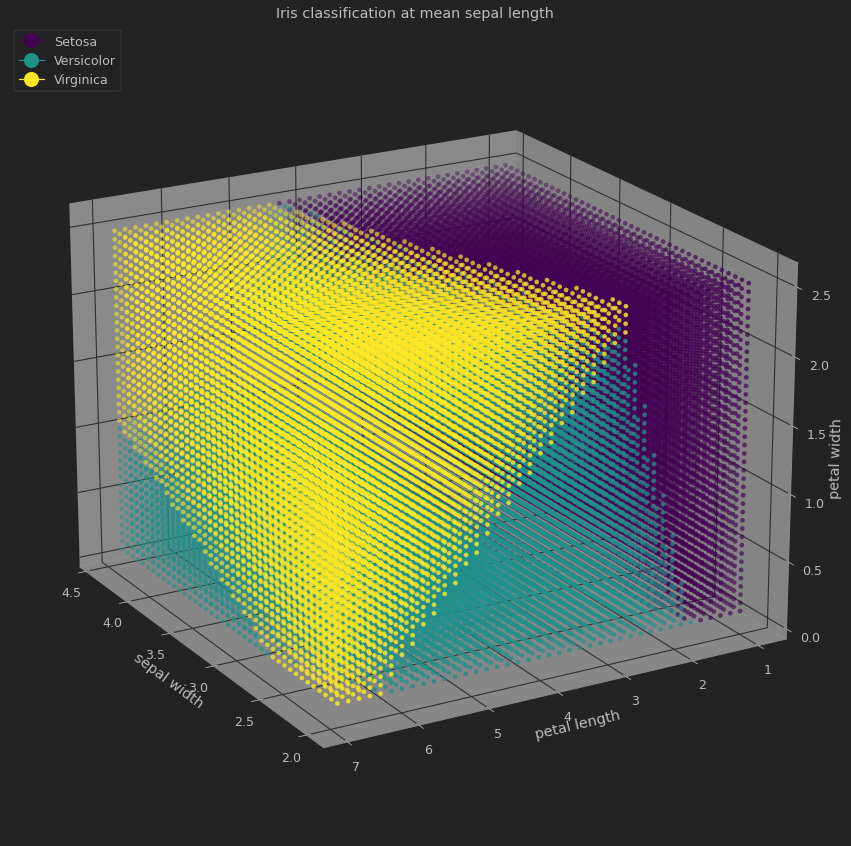

In [92]:
# importing mplot3d toolkits
from mpl_toolkits import mplot3d
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from matplotlib import cm
  
fig = plt.figure(figsize = (15, 15))
  
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
divs = 40
# defining axes
# sepal width
min_s_w = np.min(X[:, [1]])
max_s_w = np.max(X[:, [1]])
x_i = np.linspace(min_s_w, max_s_w, divs)

# petal length
min_p_l = np.min(X[:, [2]])
max_p_l = np.max(X[:, [2]])
y_i = np.linspace(min_p_l, max_p_l, divs)

# petal width
min_p_w = np.min(X[:, [3]])
max_p_w = np.max(X[:, [3]])
z_i = np.linspace(min_p_w, max_p_w, divs)

const_sl = np.mean(X[:, [0]])

[sw, pl, pw] = np.meshgrid(x_i, y_i, z_i) 

def pred(x_f):
    return sftmx_clfs[1].predict(np.array([[const_sl, x_f[0], x_f[1], x_f[2]]]))

arr = np.c_[sw.reshape(divs**3, 1), pl.reshape(divs**3, 1), pw.reshape(divs**3, 1)]
preds = np.apply_along_axis(pred, axis=1, arr=arr)

custom_cmap = cm.get_cmap('viridis', 3)
ax.scatter(sw, pl, pw, c = preds, cmap = custom_cmap)

ax.view_init(20,150)
  
# syntax for plotting
ax.set_title('Iris classification at mean sepal length')
ax.set_xlabel('sepal width')
ax.set_ylabel('petal length')
ax.set_zlabel('petal width')

legend_elements = [Line2D([0], [0], marker='o', c=custom_cmap.colors[0], label='Setosa',
                          markerfacecolor=custom_cmap.colors[0], markersize=15),
                   Line2D([0], [0], marker='o', c=custom_cmap.colors[1], label='Versicolor',
                          markerfacecolor=custom_cmap.colors[1], markersize=15),
                   Line2D([0], [0], marker='o', c=custom_cmap.colors[2], label='Virginica',
                          markerfacecolor=custom_cmap.colors[2], markersize=15)]

ax.legend(handles=legend_elements, loc = 'upper left')
plt.show()

<IPython.core.display.Javascript object>


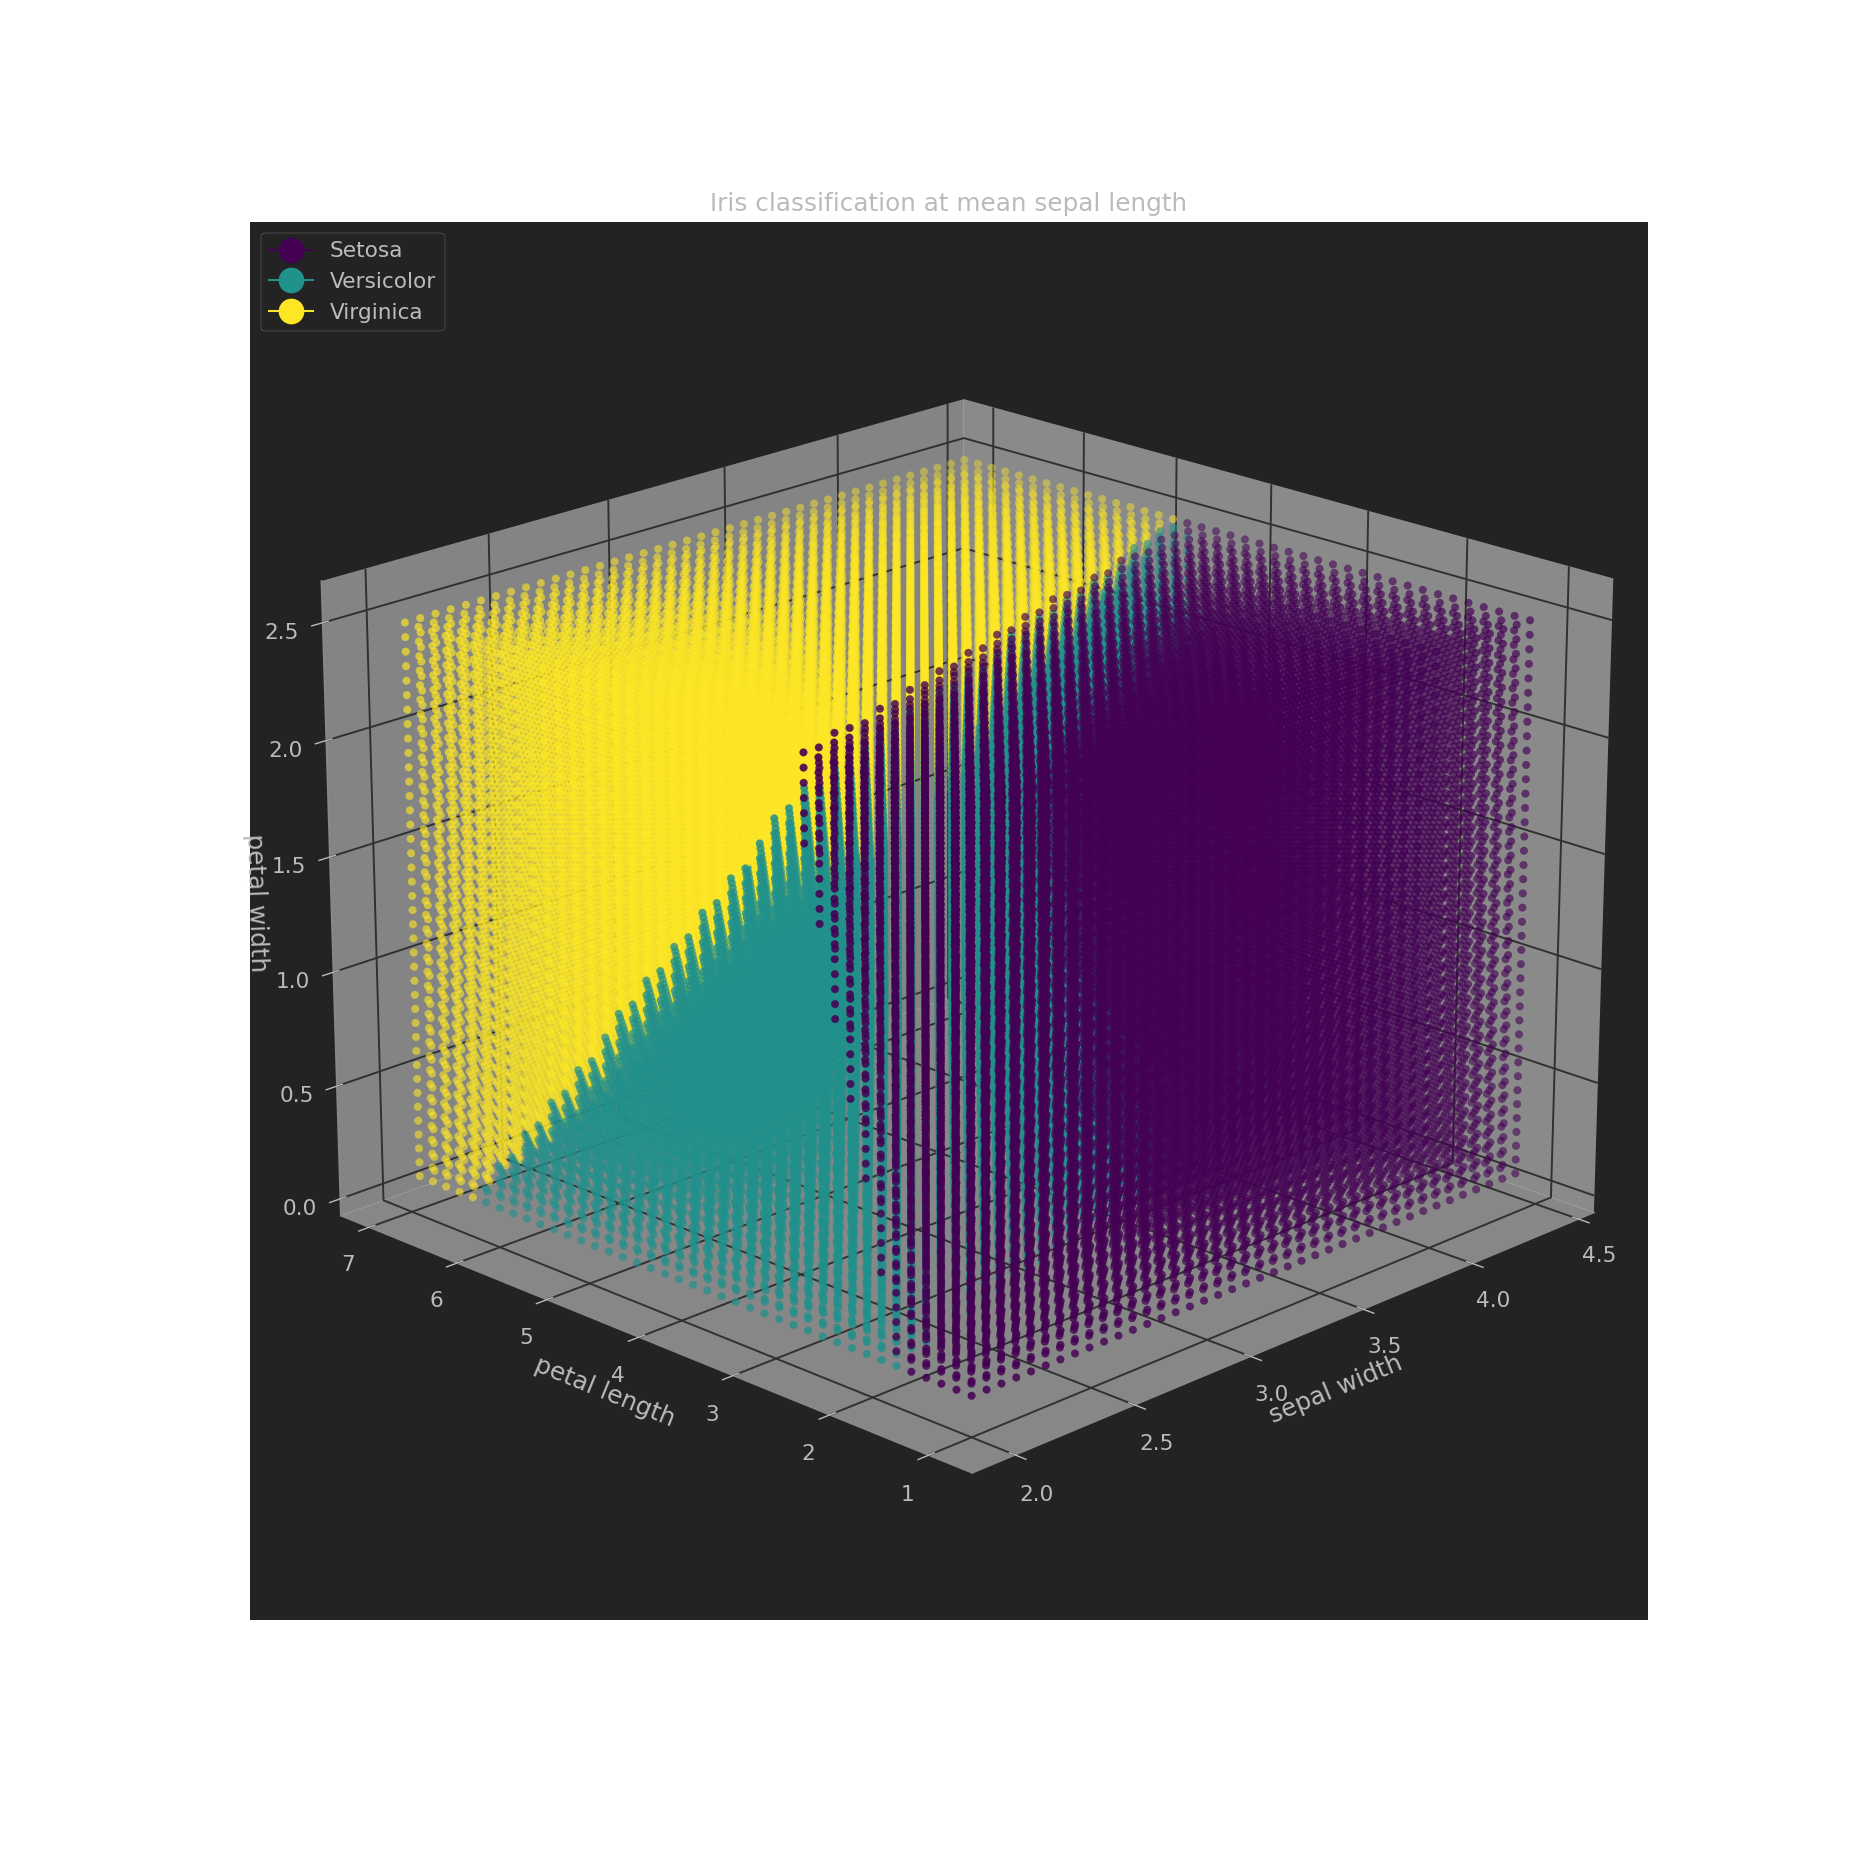

In [93]:
# importing mplot3d toolkits
%matplotlib notebook
from mpl_toolkits import mplot3d
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from matplotlib import cm
from matplotlib.animation import FuncAnimation
  
fig = plt.figure(figsize = (15, 15))
  
# syntax for 3-D projection
ax = plt.axes(projection ='3d')

def init():
    divs = 40
    # defining axes
    # sepal width
    min_s_w = np.min(X[:, [1]])
    max_s_w = np.max(X[:, [1]])
    x_i = np.linspace(min_s_w, max_s_w, divs)

    # petal length
    min_p_l = np.min(X[:, [2]])
    max_p_l = np.max(X[:, [2]])
    y_i = np.linspace(min_p_l, max_p_l, divs)

    # petal width
    min_p_w = np.min(X[:, [3]])
    max_p_w = np.max(X[:, [3]])
    z_i = np.linspace(min_p_w, max_p_w, divs)

    const_sl = np.mean(X[:, [0]])

    [sw, pl, pw] = np.meshgrid(x_i, y_i, z_i) 

    def pred(x_f):
        return sftmx_clfs[1].predict(np.array([[const_sl, x_f[0], x_f[1], x_f[2]]]))

    arr = np.c_[sw.reshape(divs**3, 1), pl.reshape(divs**3, 1), pw.reshape(divs**3, 1)]
    preds = np.apply_along_axis(pred, axis=1, arr=arr)

    custom_cmap = cm.get_cmap('viridis', 3)
    ax.scatter(sw, pl, pw, c = preds, cmap = custom_cmap)

    ax.view_init(20, 0)

    # syntax for plotting
    ax.set_title('Iris classification at mean sepal length')
    ax.set_xlabel('sepal width')
    ax.set_ylabel('petal length')
    ax.set_zlabel('petal width')

    legend_elements = [Line2D([0], [0], marker='o', c=custom_cmap.colors[0], label='Setosa',
                              markerfacecolor=custom_cmap.colors[0], markersize=15),
                       Line2D([0], [0], marker='o', c=custom_cmap.colors[1], label='Versicolor',
                              markerfacecolor=custom_cmap.colors[1], markersize=15),
                       Line2D([0], [0], marker='o', c=custom_cmap.colors[2], label='Virginica',
                              markerfacecolor=custom_cmap.colors[2], markersize=15)]

    ax.legend(handles=legend_elements, loc = 'upper left')
    
def update(frame):
    ax.view_init(20, frame)
    
ani = FuncAnimation(fig, update, frames=np.linspace(0, 360, 360),
                    init_func=init, blit=True, interval = 60)
plt.show()